In [219]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [327]:
lines = [8498.02,8542.09,8662.14]
path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

vispath = path + 'VIS_notell/'
sp = glob.glob(vispath+'*TAC.csv')

In [328]:
line_list = Table.read('line_positions.ecsv')

In [329]:
all_sp = line_list

In [330]:
len(line_list[line_list['Xs'] !=  -1.0])

24

In [331]:
line_list = line_list[line_list['Xs'] !=  -1.0]

In [332]:
sp_lines, xs = line_list['FILENAME'], line_list['Xs']

In [333]:
def get_shifted_lines(x, lines):
    #calculates the approximate positions of the shifted lines
    rest_lam = lines[0]*u.AA
    obs_lam = x*u.AA
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
    #print(dv)
    l2 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[1]*u.AA))
    l3 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[2]*u.AA))
    return np.array([x, l2.value, l3.value])

def make_plot_spec(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    smooth = 10
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne
    
    
def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error
#get_shifted_lines(xs[0], lines)

In [334]:
fitter = fitting.LevMarLSQFitter()
dvs = []
dves = []
dates = []
for s, x in zip(sp_lines, xs):
   # print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    dates.append(date)
    
    
  #  plt.figure() 
    for i in range(len(lines)):
        line = lines[i]
        guess = slines[i]
        if i == 0:
            gg_init = models.Const1D(1.0)+models.Gaussian1D(1.0, guess,1.0)    
        else:
            gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)
   #     plt.axvline(line, c='r', ls='--')
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=1000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    #print(gg_fit)
    #print(fit_e)
    
  #  plt.plot(w, f)
  #  plt.plot(w, gg_fit(w))
  #  plt.show()
    obs_lines = [gg_fit[1].mean*u.AA, gg_fit[2].mean*u.AA, gg_fit[3].mean*u.AA]
    obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]
    
    e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
    e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
    es = np.mean([e_up, e_down], axis=0)
    #print(len(es))
    dv, dve = dv_average(dv, es)
    dvs.append(dv)
    dves.append(dve)
    
    #dvs.append(np.mean(dv))
    #print(np.std(dv))
    
    

<ErrorbarContainer object of 3 artists>

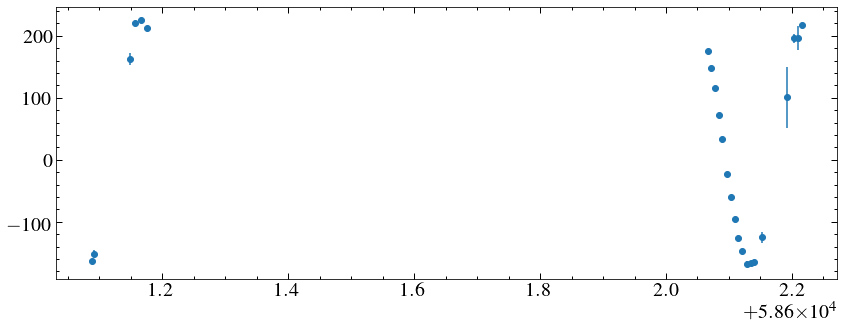

In [335]:
plt.errorbar(dates, dvs, yerr=dves, marker='o', ls='none')

In [336]:
from astropy.timeseries import LombScargle

In [337]:

dates = np.array(dates) + (150/86400)
args = np.argsort(dates)

In [338]:
t = dates[args]
dvs = np.array(dvs)[args]
dves= np.array(dves)[args]
t_unnorm = t*24
t = (t-t[0])*24

4.217385925598945


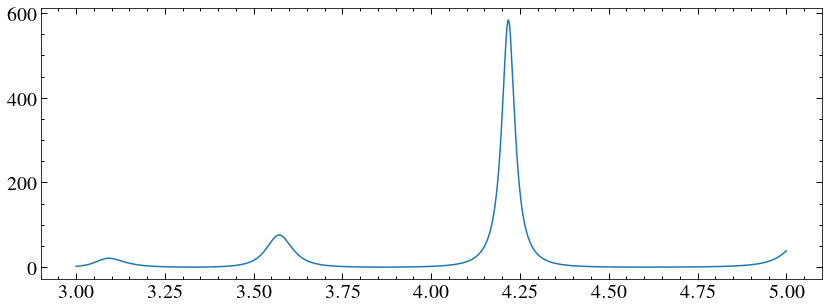

In [234]:

frequency = np.linspace(1/5, 1/3, 100000)
power = LombScargle(t, dvs, normalization='model').power(frequency)
period = 1/frequency[np.argmax(power)]
print(period)
plt.plot(1/frequency, power)

<ErrorbarContainer object of 3 artists>

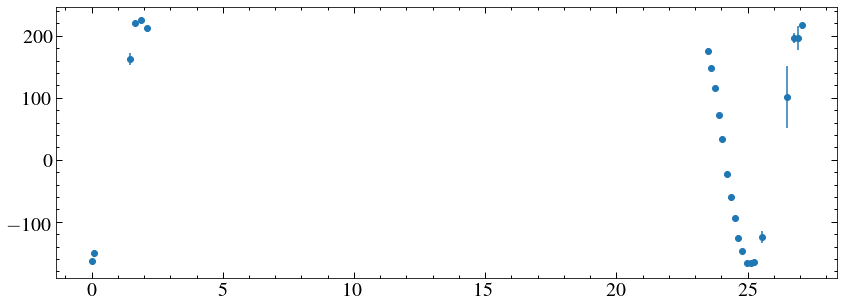

In [235]:
t_fold = (t/period) %1
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')

Can't deal with errors for some reason -fixed- weights = 1/e

Try the absorption lines?

In [240]:
abs_dates = []
for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    abs_dates.append(date)
abs_args = np.argsort(abs_dates)

<ErrorbarContainer object of 3 artists>

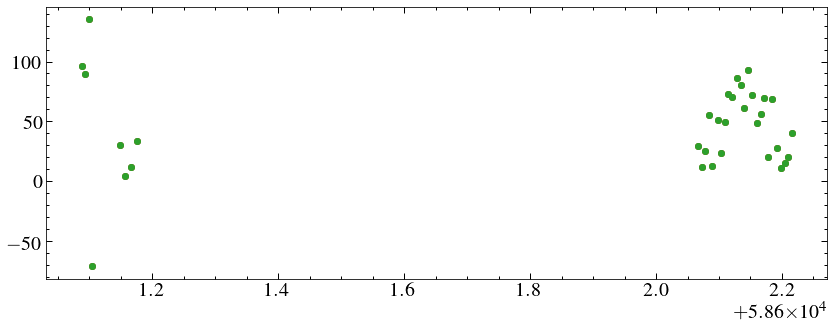

In [263]:
plt.errorbar(abs_dates, dvs_1, ls='none', marker='o')
plt.errorbar(abs_dates, dvs_2, ls='none', marker='o')
plt.errorbar(abs_dates, dvs_3, ls='none', marker='o')

Great, it doesn't depend on which gaussian is used. Try doing it once and bruteforce it to get the errors

In [386]:
fitter = fitting.LevMarLSQFitter()
abs_dvs = []
abs_dves = []
abs_dates = []
halpha = 6562.77
h_em = []
h_eme = []
dvs_1 = []
dvs_1e = []
#dvs_2 = []

#dvs_3 = []

def tiedfunc0(gg_init):
    mean = gg_init.mean_0.value
    return mean

for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
#for s, x in zip(sp_lines, xs):
    print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
    mask2 = (w> 6400) & (w < 6800) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    #abs_dates.append(date)
    
    
  #  plt.figure() 
  #, bounds={'amplitude':[-0.1, -0.3]}
   # plt.axvline(halpha, c='r', ls='--')
    gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.4, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0) 

    gg_init.stddev_1.bounds = [0.1, 1.2]
    gg_init.stddev_0.bounds = [1.5,6]
    
    if x != -1:
        rest_lam = lines[0]*u.AA
        obs_lam = x*u.AA
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
        h_guess = dv.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    else:
    #    h_guess = halpha-5
        dt_fold = (date*24)/period %1
        h_guess = sine_fit(dt_fold)*u.km/u.s
        h_guess = h_guess.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    gg_init += models.Gaussian1D(1.0, h_guess,0.5, bounds={'mean':[h_guess-1, h_guess+1], 'stdev':[0.1, 3]})
    gg_init.mean_1.tied=tiedfunc0
    gg_init.mean_2.tied=tiedfunc0
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=100000)
    #print(gg_fit)
    #print(fitter.fit_info['param_cov'])
    obs_lam = gg_fit[1].mean*u.AA
    abs_dates.append(date)
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
    dvs_1.append(dv)
     
    em_line = gg_fit[4].mean*u.AA
    dv_em = em_line.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
    h_em.append(dv_em)
    
    if fitter.fit_info['param_cov'] is None:
        dvs_1e.append(15)
        h_eme.append(15)
    else:
       # print('yes')
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        #print(len(fit_e))
       # print (fitter.fit_info)
        e_lam = fit_e[1]*u.AA
        e_up = (obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value         
        e_down = (obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value 
        e_up = abs(e_up- dv)        
        e_down = abs(e_down-dv) 
        es = np.mean([e_up, e_down])
        dvs_1e.append(es)
        
        e_lam = fit_e[9]*u.AA
        e_up = (em_line+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value         
        e_down = (em_line-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value 
        e_up = abs(e_up- dv_em)        
        e_down = abs(e_down-dv_em) 
        es = np.mean([e_up, e_down])
        h_eme.append(es)
        
        
        
    
    
    

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_30_TAC.csv


/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_21_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_2_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_16_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_14_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_8_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_27_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_29_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ11440

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in sqrt


/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_6_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_32_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_22_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_19_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_24_TAC.csv


33 33 33


<ErrorbarContainer object of 3 artists>

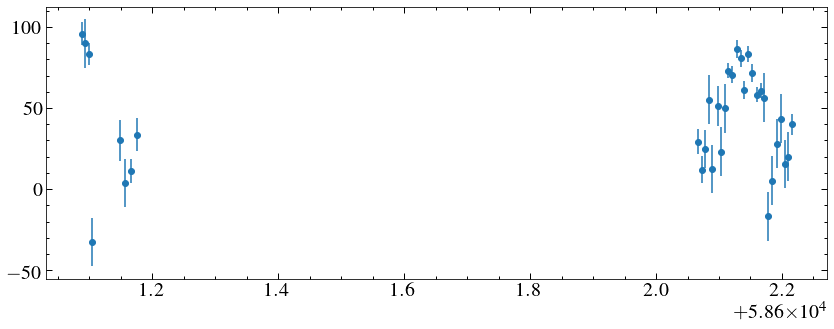

In [387]:
print(len(abs_dates), len(dvs_1), len(dvs_1e))
plt.errorbar(abs_dates, dvs_1, yerr=dvs_1e, ls='none', marker='o')

Failed fits have been given a guess error of 15 km/s. LS?

Fold on original periio

Yeah I'll take it - Need the 2018 data though.

In [268]:
old_path = '/home/david/work/1144_lt/spectra/SDSSJ1144_old/'
old_spec = glob.glob(old_path+'*VIS*.csv')
old_spec

['/home/david/work/1144_lt/spectra/SDSSJ1144_old/SDSS1144_2_SCI_SLIT_FLUX_MERGE1D_VIS_TAC.csv',
 '/home/david/work/1144_lt/spectra/SDSSJ1144_old/SDSS1144_1_SCI_SLIT_FLUX_MERGE1D_VIS_TAC.csv']

So 2 is clean and can be fit normallly. 1 needs 2 fits and we can use the rest to guess where it fits in.

/home/david/work/1144_lt/spectra/SDSSJ1144_old/SDSS1144_2_SCI_SLIT_FLUX_MERGE1D_VIS_TAC.csv


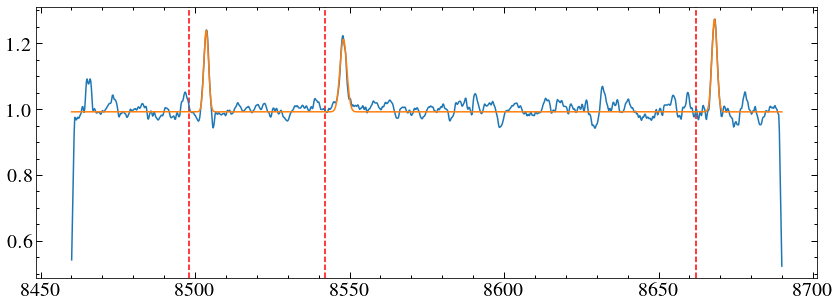

/home/david/work/1144_lt/spectra/SDSSJ1144_old/SDSS1144_1_SCI_SLIT_FLUX_MERGE1D_VIS_TAC.csv


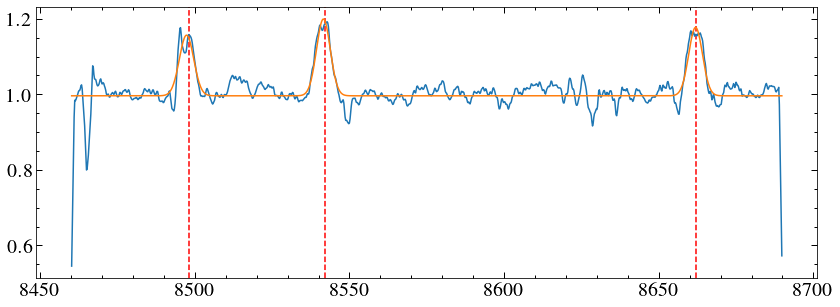

[204.8822752255248, -17.86201822384454] [2.6964617937588966, 3.7303943258170085]


In [270]:
fitter = fitting.LevMarLSQFitter()
old_dvs = []
old_dves = []
old_dates = []
old_xs = [8503.73,8498.5]
for s, x in zip(old_spec, old_xs):
    print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
  #  plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    old_dates.append(date)
    
    #print(slines)
    plt.figure() 
    for i in range(len(lines)):
        line = lines[i]
        guess = slines[i]
        if i == 0:
            gg_init = models.Const1D(1.0)+models.Gaussian1D(1.0, guess,1.0)    
        else:
            gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)
        plt.axvline(line, c='r', ls='--')
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=10000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    #print(gg_fit)
    #print(fit_e)
    
    plt.plot(w, f)
    plt.plot(w, gg_fit(w))
    plt.show()
    obs_lines = [gg_fit[1].mean*u.AA, gg_fit[2].mean*u.AA, gg_fit[3].mean*u.AA]
    obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]
    
    e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
    e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
    es = np.mean([e_up, e_down], axis=0)
   # print(len(es))
    dv, dve = dv_average(dv, es)
    old_dvs.append(dv)
    old_dves.append(dve)
print(old_dvs, old_dves)

Ok, first one worked, need a different approach to second.

Model: CompoundModel2822
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6]
Components: 
    [0]: <Const1D(amplitude=1.)>

    [1]: <Gaussian1D(amplitude=1., mean=8494.8, stddev=1.)>

    [2]: <Gaussian1D(amplitude=1., mean=8538.85330136, stddev=1.)>

    [3]: <Gaussian1D(amplitude=1., mean=8658.857813, stddev=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=8498.2, stddev=1.)>

    [5]: <Gaussian1D(amplitude=1., mean=8542.27093346, stddev=1.)>

    [6]: <Gaussian1D(amplitude=1., mean=8662.32347629, stddev=1.)>
Parameters:
       amplitude_0        amplitude_1     ...       mean_6          stddev_6    
    ----------------- ------------------- ... ----------------- ----------------
    0.993925840254146 0.15576301736529255 ... 8663.292975158978 1.38893334660298


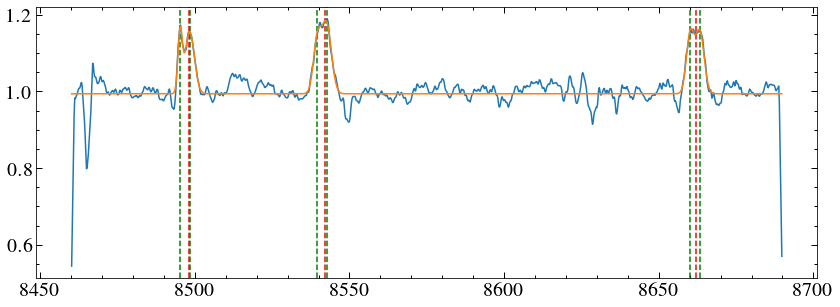

[-97.49333095478698, -86.09507923237399, -68.18102747074032] [16.1123309  97.24950047 83.82269186]
[11.849586364299334, 19.863882135187843, 39.90391022581203] [16.44268693 89.78918487 83.43620053]
[-96.18186760319136, 13.116201756990355] [3.9658673820043617, 3.8017935474268123]


In [271]:
b_dvs = []
b_dvs_e = []
w, f, e = np.loadtxt(old_spec[1], unpack=True, delimiter=',')
oxs = [8494.8, 8498.2]

slines = get_shifted_lines(oxs[0], lines)
mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
mask2 = (w> 8460) & (w < 8690) 
w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
#  plt.plot(w, f)
date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
old_dates.append(date)

#print(slines)
plt.figure() 
for i in range(len(lines)):
    line = lines[i]
    guess = slines[i]
    if i == 0:
        gg_init = models.Const1D(1.0)+models.Gaussian1D(1.0, guess,1.0)    
    else:
        gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)
    plt.axvline(line, c='r', ls='--')
    
#add a second set of gaussians
slines = get_shifted_lines(oxs[1], lines)
for i in range(len(lines)):
    line = lines[i]
    guess = slines[i]
    gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)

    
    
gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=10000)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

print(gg_fit)
#print(fit_e)

for i in range(6):
    line = gg_fit[i+1].mean.value
    plt.axvline(line, c='g', ls='--') 

plt.plot(w, f)
plt.plot(w, gg_fit(w))
plt.show()
obs_lines = [gg_fit[1].mean*u.AA, gg_fit[2].mean*u.AA, gg_fit[3].mean*u.AA]
obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]

e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
es = np.mean([e_up, e_down], axis=0)
# print(len(es))
print(dv, es)
dv, dve = dv_average(dv, es)
b_dvs.append(dv)
b_dvs_e.append(dve)

obs_lines = [gg_fit[4].mean*u.AA, gg_fit[5].mean*u.AA, gg_fit[6].mean*u.AA]
obs_e = [fit_e[11]*u.AA, fit_e[14]*u.AA, fit_e[17]*u.AA]
dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]

e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
es = np.mean([e_up, e_down], axis=0)
# print(len(es))
print(dv, es)
dv, dve = dv_average(dv, es)
b_dvs.append(dv)
b_dvs_e.append(dve)

print(b_dvs, b_dvs_e)

Tada!

Add the first one then find the dates for the second.

In [272]:
fits.getheader(old_spec[0][:-3]+'fits')['EXPTIME']

1440.0

In [273]:
date1, dv1, dve1 = old_dates[0], old_dvs[0], old_dves[0]

In [274]:
date1 += 1440/86400
time1 = date1*24

In [276]:
all_t = np.append(time1,t_unnorm)
all_dvs = np.append(dv1, dvs )
all_dves = np.append(dve1, dves)
aargs = np.argsort(all_t)
all_t, all_dvs, all_dves = all_t[aargs], all_dvs[aargs], all_dves[aargs]

4.219993247944445


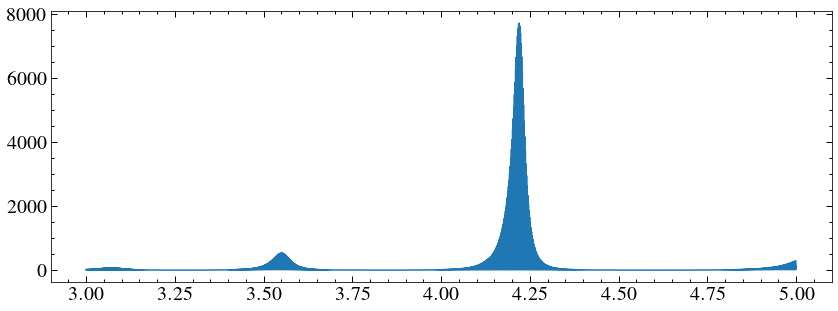

In [325]:
#frequency = np.linspace(1/5, 1/3, 100000)
#power = LombScargle(all_t, all_dvs, all_dves, normalization='model').power(frequency)
frequency, power = LombScargle(all_t, all_dvs, all_dves, normalization='model').autopower(minimum_frequency = 1/5, maximum_frequency = 1/3)
period = 1/frequency[np.argmax(power)]
print(period)
plt.plot(1/frequency, power)
#plt.xlim(2, 10)

<ErrorbarContainer object of 3 artists>

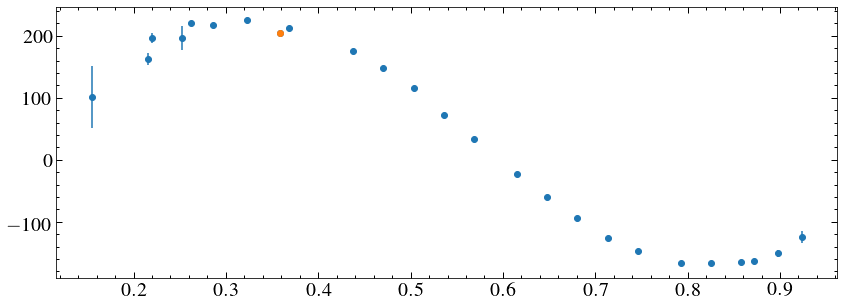

In [279]:
plt.errorbar((all_t/period %1), all_dvs, yerr=all_dves, marker='o', ls='none')
plt.errorbar((time1/period %1), dv1, yerr=dve1, marker='o', ls='none')

Ok, now how about the other spectrum?

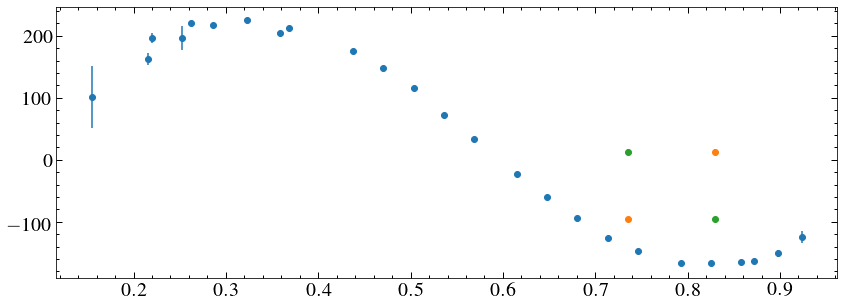

4.211460863763268


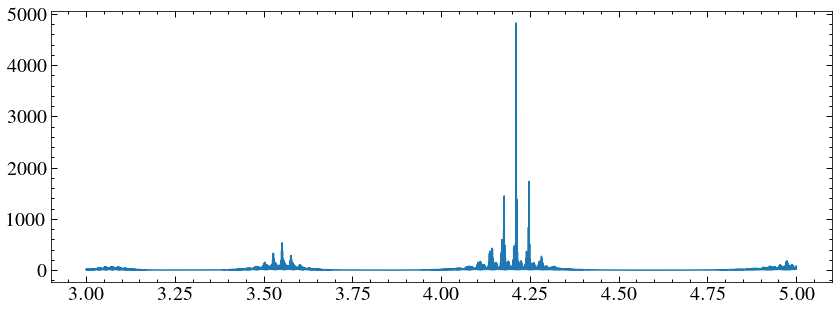

4.22512929372743


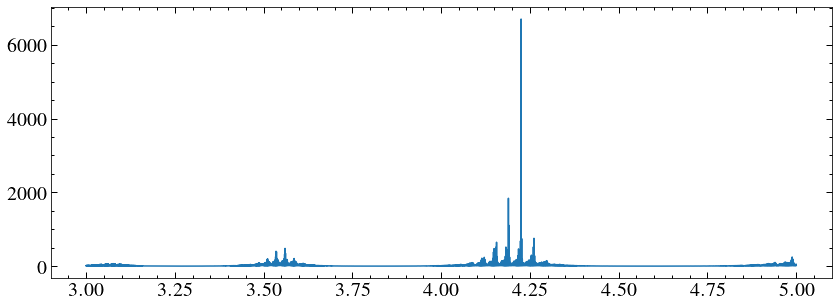

In [280]:
texp = 1440/86400
test_1 = np.array([old_dates[1]+texp/2, old_dates[1]+texp*1.5 ])*24
test_2 = test_1[::-1]
plt.errorbar((all_t/period %1), all_dvs, yerr=all_dves, marker='o', ls='none')
for test in [test_1, test_2]:
    plt.errorbar((test/period %1), b_dvs, yerr=b_dvs_e, marker='o', ls='none')
plt.show()
for test in [test_1, test_2]:
    frequency, power = LombScargle(np.append(all_t, test), np.append(all_dvs, b_dvs), np.append(all_dves, b_dvs_e), normalization='model').autopower(minimum_frequency = 1/5, maximum_frequency = 1/3)
    period = 1/frequency[np.argmax(power)]
    print(period)
    plt.plot(1/frequency, power)
    plt.show()
        

In [281]:
b_times = [58189.097671+(720/86400), 58189.080295+(720/86400)] #checking eso archive
b_days = np.array(b_times)*24


In [359]:
all_t1 = np.concatenate((b_days,all_t))
all_dvs1 = np.concatenate((b_dvs, all_dvs))
all_dves1 = np.concatenate((b_dvs_e, all_dves))
aargs = np.argsort(all_t1)
all_t1, all_dvs1, all_dves1 = all_t1[aargs], all_dvs1[aargs], all_dves1[aargs]

4.22512929372743


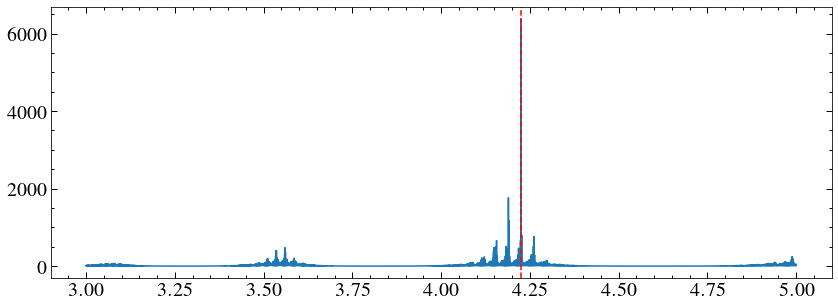

4.221516440156591


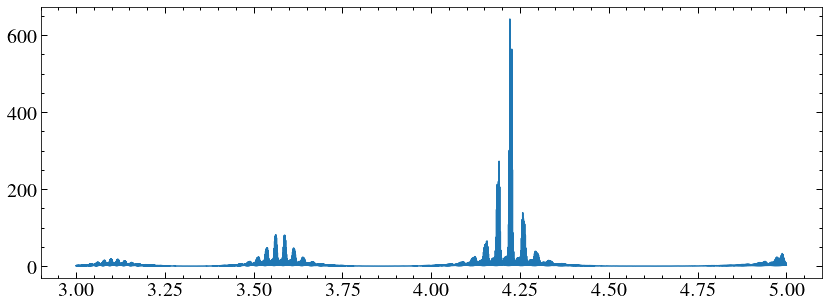

In [360]:
frequency, power = LombScargle(all_t1, all_dvs1, all_dves1, normalization='model').autopower(minimum_frequency = 1/5, maximum_frequency = 1/3)
period = 1/frequency[np.argmax(power)]
print(period)
plt.plot(1/frequency, power)
plt.axvline(period, ls='--', c='r')
plt.show()
frequency = np.linspace(1/5, 1/3, 100000)
power = LombScargle(all_t1, all_dvs1, normalization='model').power(frequency)
period = 1/frequency[np.argmax(power)]
print(period)
plt.plot(1/frequency, power)
plt.show()

<ErrorbarContainer object of 3 artists>

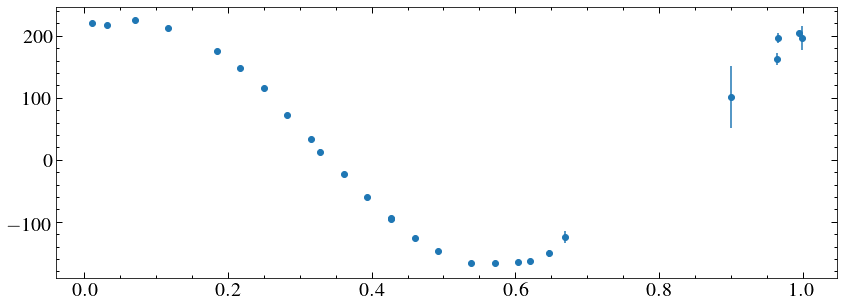

In [361]:
plt.errorbar((all_t1/period %1), all_dvs1, yerr=all_dves1, marker='o', ls='none')


Save the Ca ii lines to file while we're here:

In [288]:
ca_dat = Table([(all_t1/24)*u.d, all_dvs1*u.km/u.s, all_dves1*u.km/u.s], names=['MJD', 'VELOCITY', 'ERROR'])
ca_dat.write('ca_dvs.ecsv', format='ascii.ecsv', overwrite=True)

Abs lines next...ditch the 2nd spectrum until I can reinstall reflex and do a proper stare reduction.

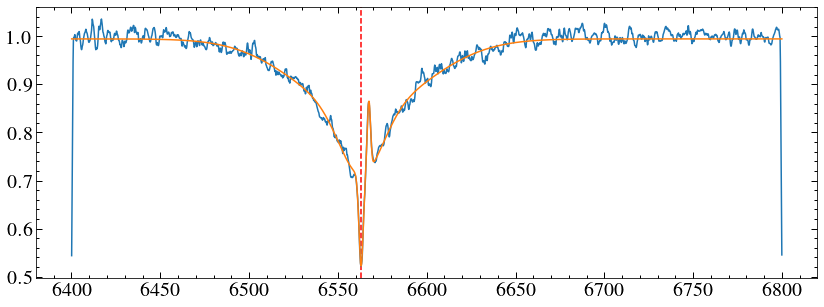

In [351]:

    

fitter = fitting.LevMarLSQFitter()

halpha = 6562.77

def tiedfunc(gg_init):
    mean = gg_init.mean_1.value
    return mean


x = 6567.5
w, f, e = np.loadtxt(old_spec[0], unpack=True, delimiter=',')

#slines = get_shifted_lines(x, lines)
mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
mask2 = (w> 6400) & (w < 6800) 
w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
#plt.plot(w, f)
#old_date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
#abs_dates.append(date)


plt.figure() 
#, bounds={'amplitude':[-0.1, -0.3]}
plt.axvline(halpha, c='r', ls='--')
gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.4, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0) 

gg_init.stddev_1.bounds = [0.1, 1.2]
gg_init.stddev_0.bounds = [1.5,6]

rest_lam = halpha*u.AA
obs_lam = x*u.AA
#dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
#h_guess = dv.to(u.AA, equivalencies=u.doppler_o_ptical(halpha*u.AA)).value
h_guess = x  

gg_init += models.Gaussian1D(1.0, h_guess,0.5)#, bounds={'mean':[h_guess-1, h_guess+1], 'stdev':[0.1, 3]})
gg_init.mean_0.tied=tiedfunc
gg_init.mean_2.tied=tiedfunc


gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=100000)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

#print(gg_fit)
#print(fit_e)

plt.plot(w, f)
plt.plot(w, gg_fit(w))
plt.show()

obs_lam = gg_fit[1].mean*u.AA
#obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
dv = obs_line.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
e_lam = fit_e[1]*u.AA
e_up = (obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value         
e_down = (obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value 
e_up = abs(e_up- dv)        
e_down = abs(e_down-dv) 
es = np.mean([e_up, e_down])

dv_a_old = dv
dv_a_old_e = es


em_line = gg_fit[4].mean*u.AA
dv_em = em_line.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value

e_lam = fit_e[9]*u.AA
e_up = (em_line+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value         
e_down = (em_line-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value 
e_up = abs(e_up- dv_em)        
e_down = abs(e_down-dv_em) 
es = np.mean([e_up, e_down])
dv_em_old = dv_em
dv_em_old_e = es


<ErrorbarContainer object of 3 artists>

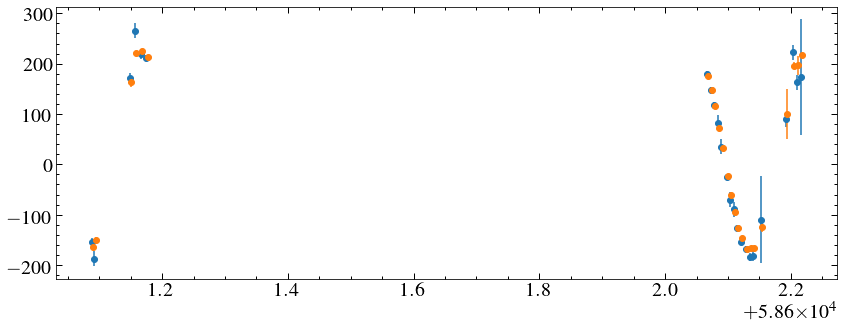

In [362]:
plt.errorbar(abs_dates, h_em, yerr=h_eme, marker='o', ls='none')
plt.errorbar(t_unnorm/24, dvs, yerr=dves, marker='o', ls='none')

Can we use the emission lines to correct the absorption lines?

In [340]:
#hem_dat = Table([(abs_dates)*u.d, h_em*u.km/u.s, h_eme*u.km/u.s], names=['MJD', 'VELOCITY', 'ERROR'])
#hem_dat.write('hem_dvs.ecsv', format='ascii.ecsv', overwrite=True)

<ErrorbarContainer object of 3 artists>

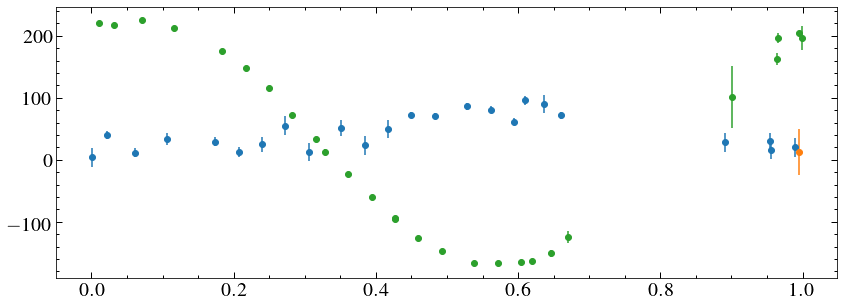

In [377]:
plt.errorbar((abs_dates/(period/24) %1), dvs_1, yerr=dvs_1e, ls='none', marker='o')
plt.errorbar((date1/(period/24) %1), dv_a_old, yerr=dv_a_old_e, ls='none', marker='o')
plt.errorbar((all_t1/period %1), all_dvs1, yerr=all_dves1, marker='o', ls='none')


<ErrorbarContainer object of 3 artists>

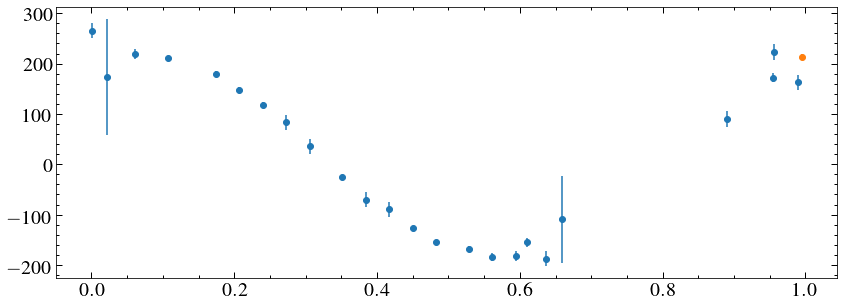

In [365]:
plt.errorbar((abs_dates/(period/24) %1), h_em, yerr=h_eme, marker='o', ls='none')
plt.errorbar((date1/(period/24) %1), dv_em_old, yerr=dv_em_old_e, ls='none', marker='o')


In [388]:
htime = np.append(date1, abs_dates)
ha_em = np.append(dv_em_old, h_em)
ha_eme = np.append(dv_em_old_e, h_eme)
ha_ab = np.append(dv_a_old, dvs_1)
ha_abe = np.append(dv_a_old_e, dvs_1e)
ha_args = np.argsort(htime)
htime, ha_em, ha_eme, ha_ab, ha_abe = htime[ha_args], ha_em[ha_args], ha_eme[ha_args], ha_ab[ha_args], ha_abe[ha_args]
len(htime)

34

(58600, 58605)

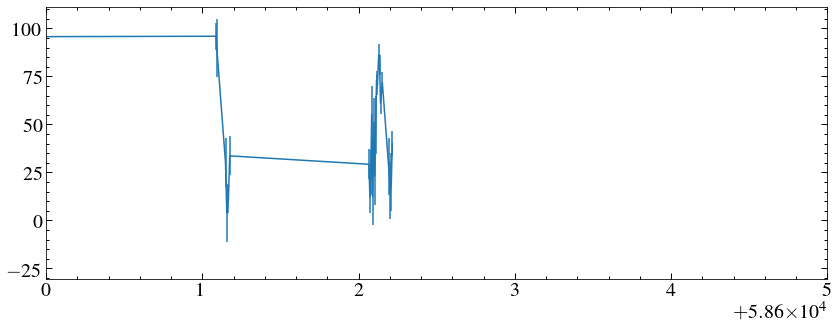

In [379]:
#plt.errorbar(htime, ha_em, yerr=ha_eme)
plt.errorbar(htime, ha_ab, yerr=ha_abe)

plt.xlim(58600, 58605)

In [389]:
hem_dat = Table([htime*u.d, ha_em*u.km/u.s, ha_eme*u.km/u.s], names=['MJD', 'VELOCITY', 'ERROR'])
hem_dat.write('dv_lists/ha_em_dvs.ecsv', format='ascii.ecsv', overwrite=True)

In [390]:
hab_dat = Table([htime*u.d, ha_ab*u.km/u.s, ha_abe*u.km/u.s], names=['MJD', 'VELOCITY', 'ERROR'])
hab_dat.write('dv_lists/ha_ab_dvs.ecsv', format='ascii.ecsv', overwrite=True)

New idea- what if I remove the h alpha core and fit that?

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_30_TAC.csv


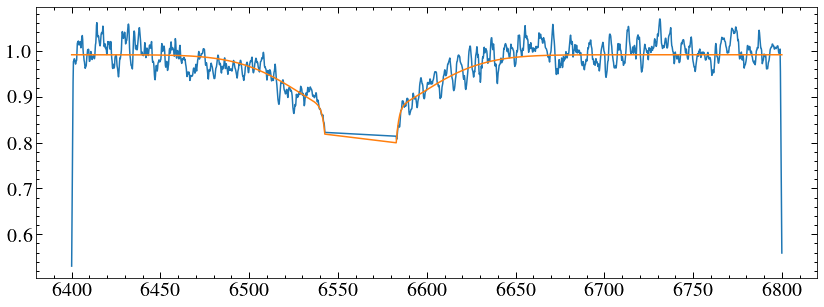

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_21_TAC.csv


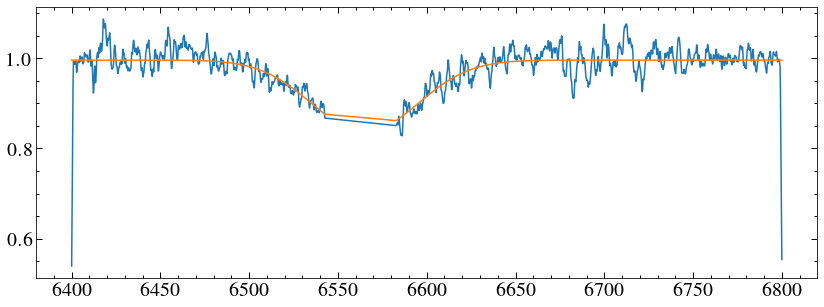

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_2_TAC.csv


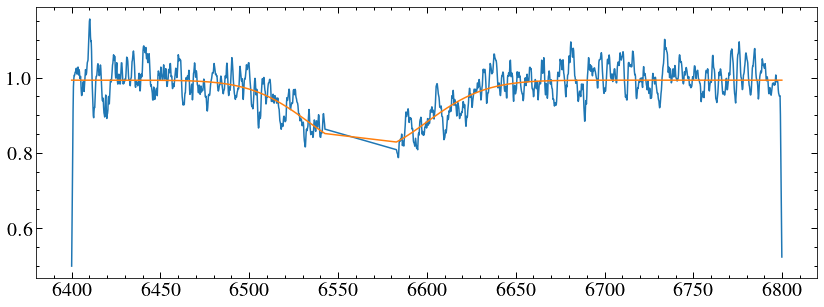

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_16_TAC.csv


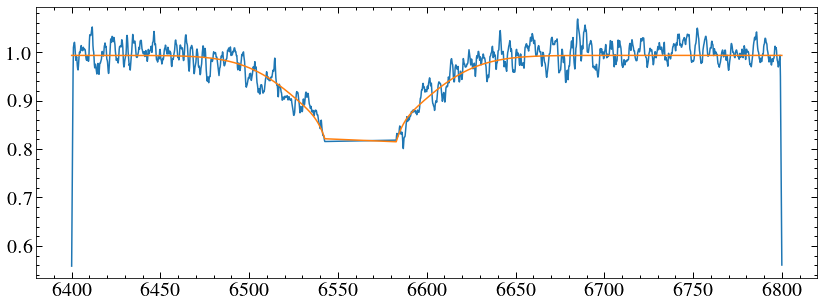

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_14_TAC.csv


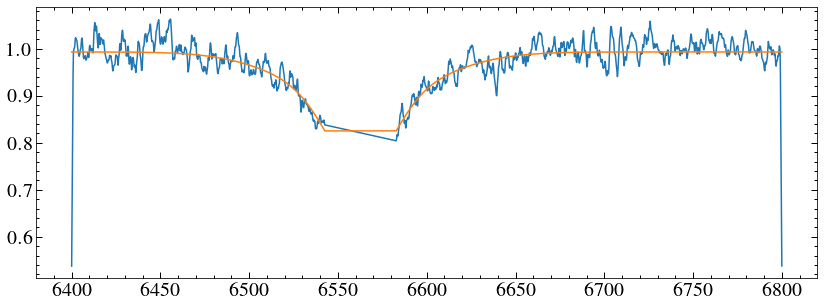

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_8_TAC.csv


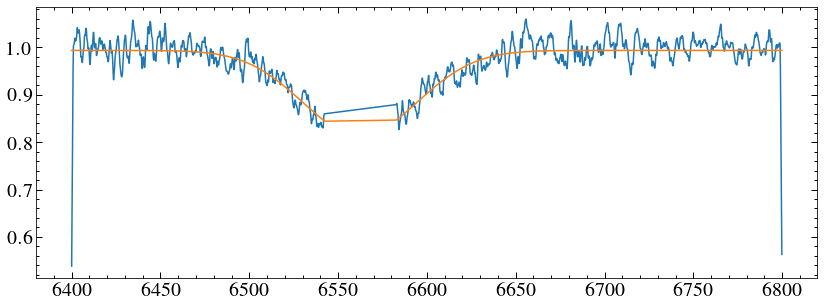

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_27_TAC.csv


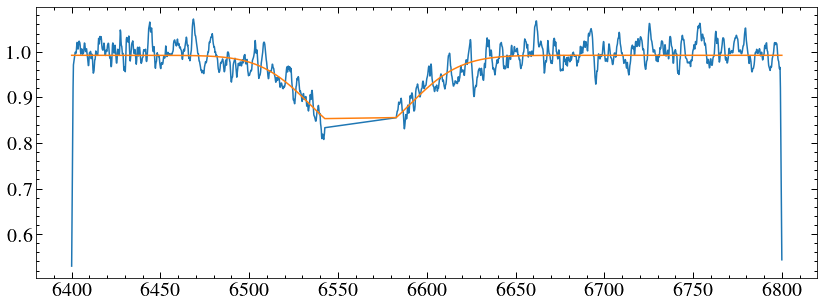

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_29_TAC.csv


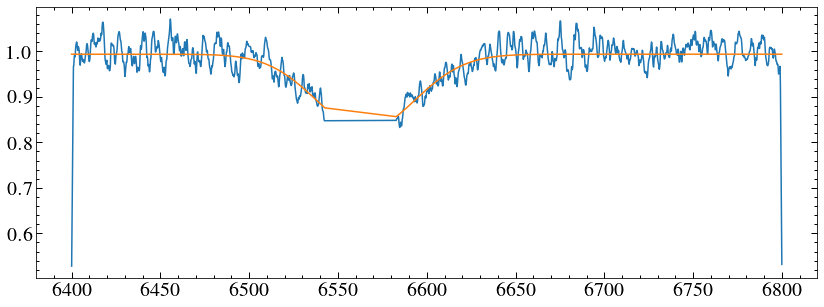

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_23_TAC.csv


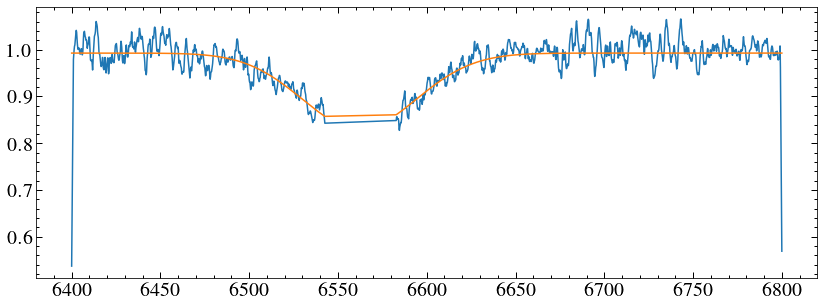

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_26_TAC.csv


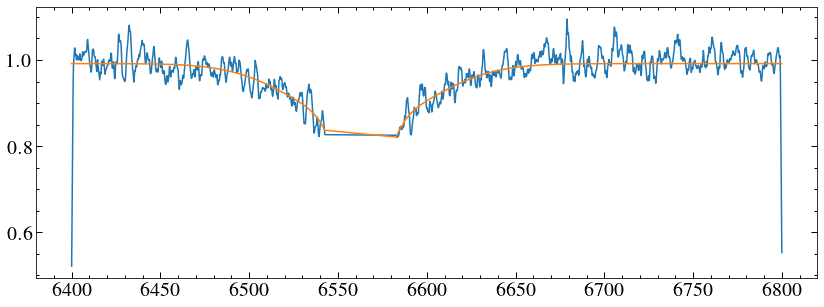

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_1_TAC.csv


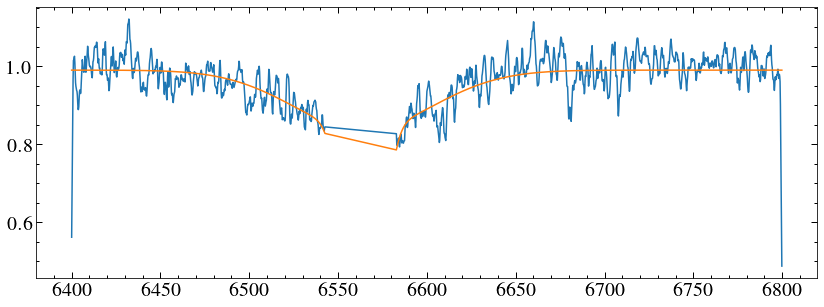

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_11_TAC.csv


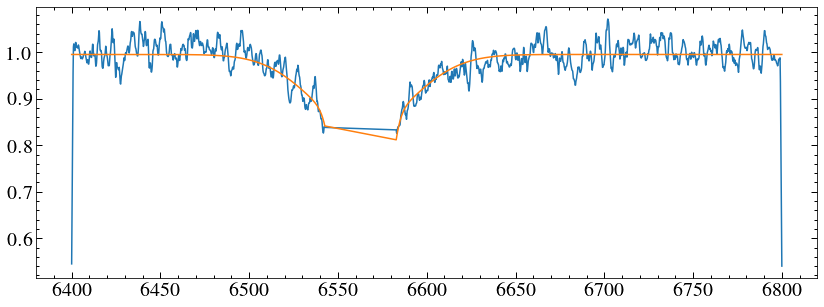

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_28_TAC.csv


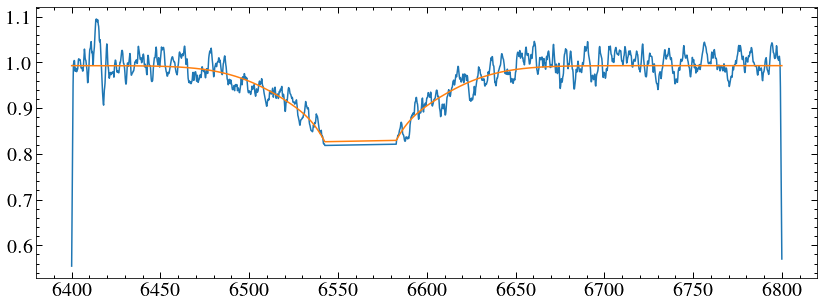

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_12_TAC.csv


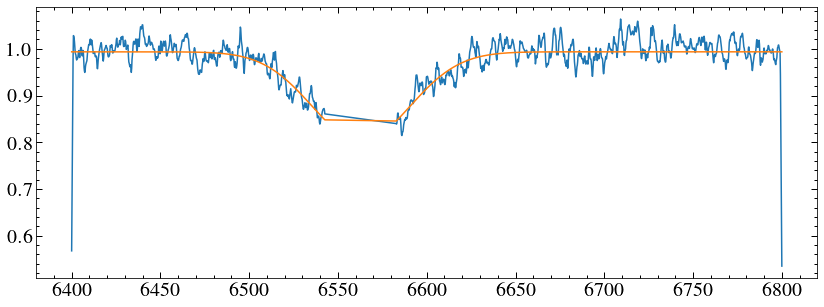

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_4_TAC.csv


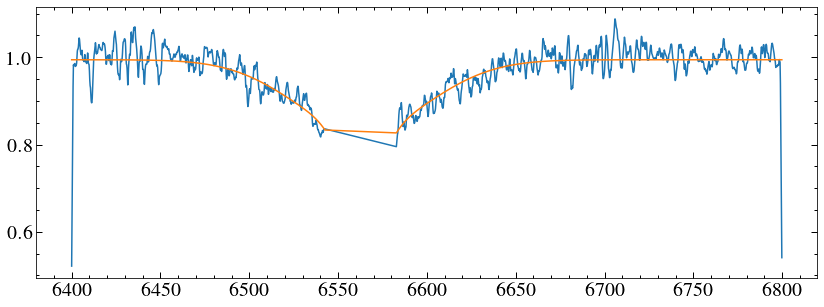

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_25_TAC.csv


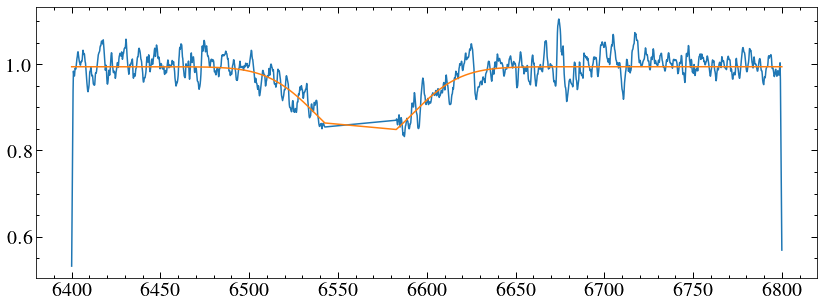

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_31_TAC.csv


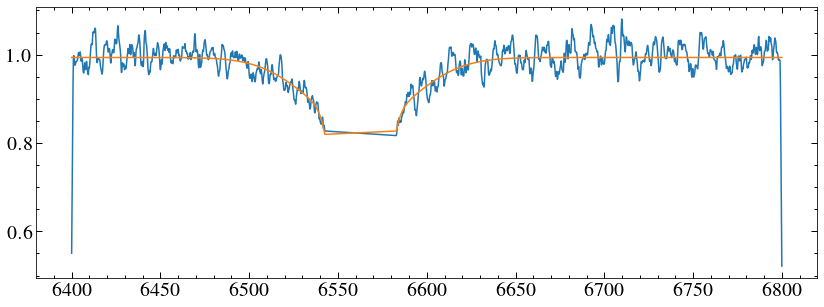

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_9_TAC.csv


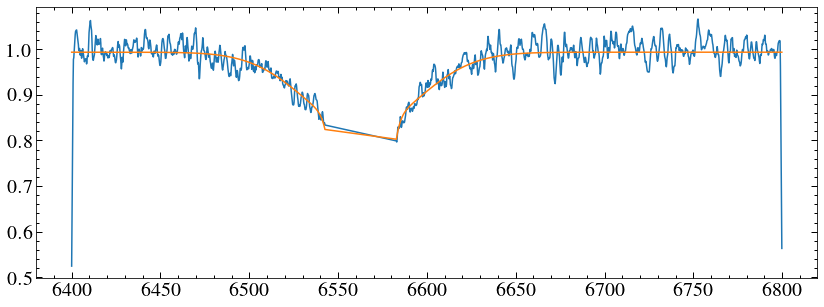

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_0_TAC.csv


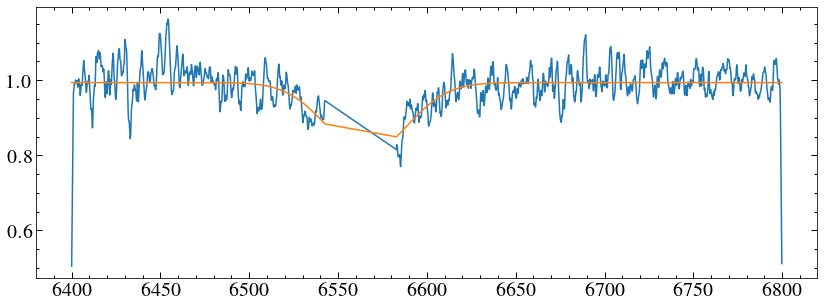

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_20_TAC.csv


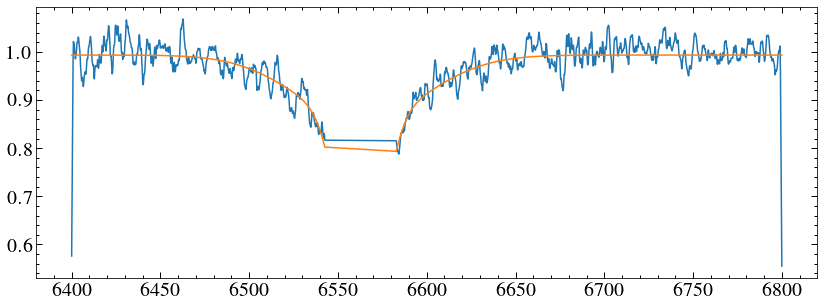

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_5_TAC.csv


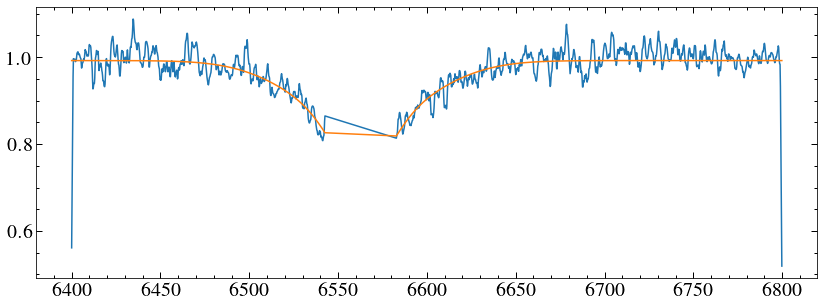

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_18_TAC.csv


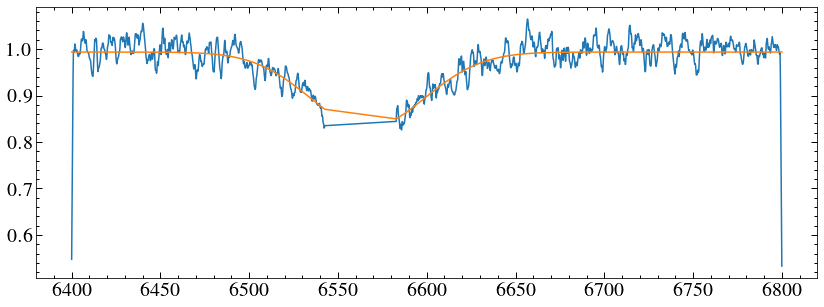

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_3_TAC.csv


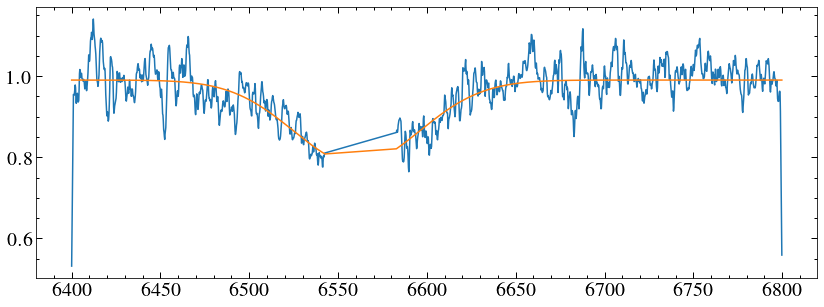

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_10_TAC.csv


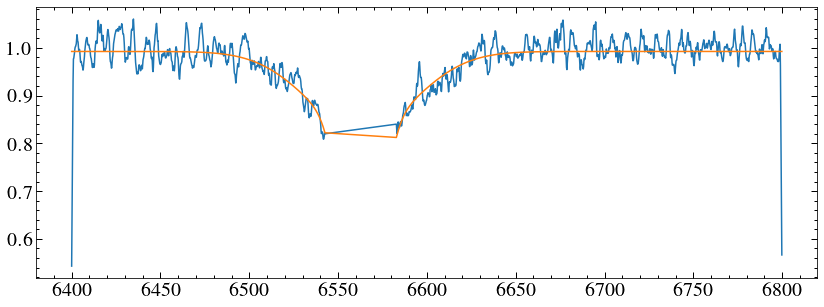

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_13_TAC.csv


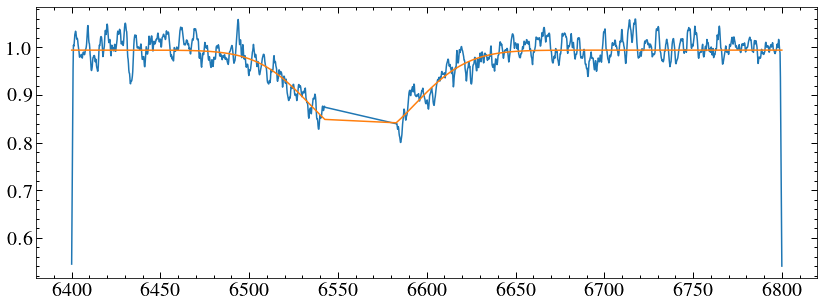

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_15_TAC.csv


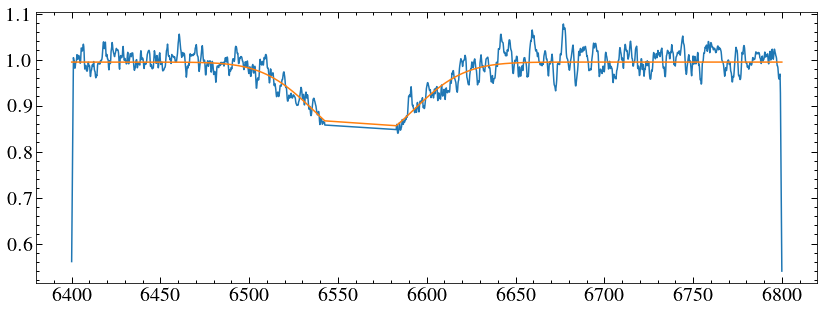

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_17_TAC.csv


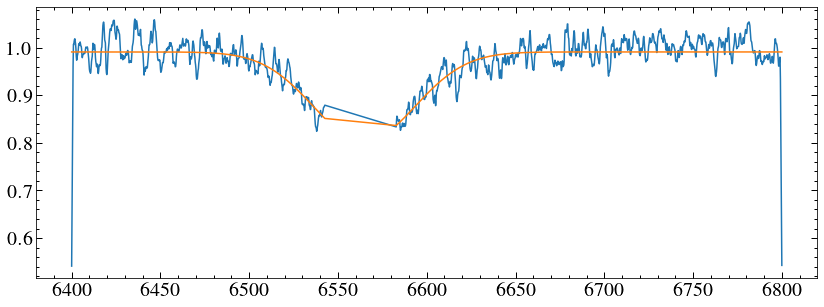

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_7_TAC.csv


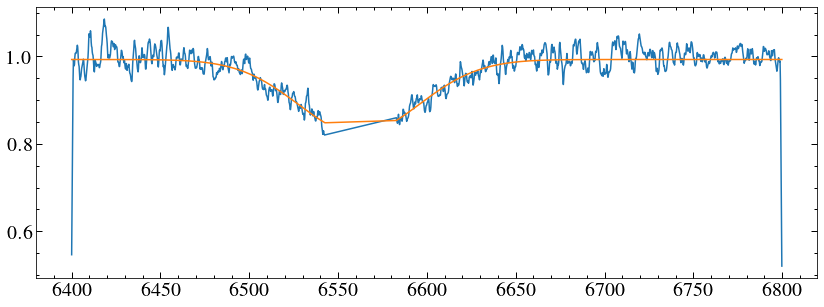

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_6_TAC.csv


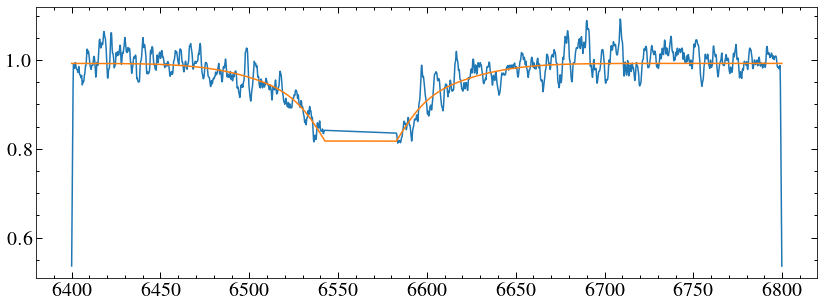

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_32_TAC.csv


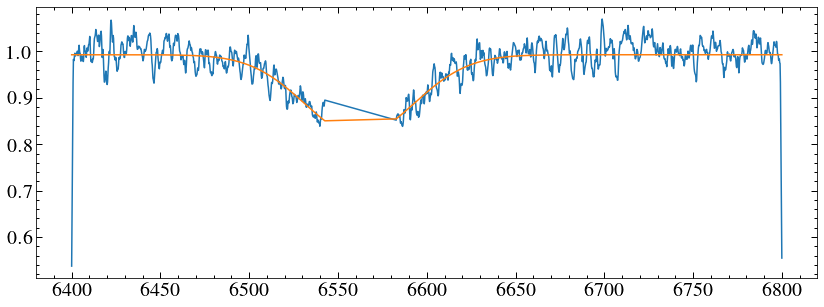

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_22_TAC.csv


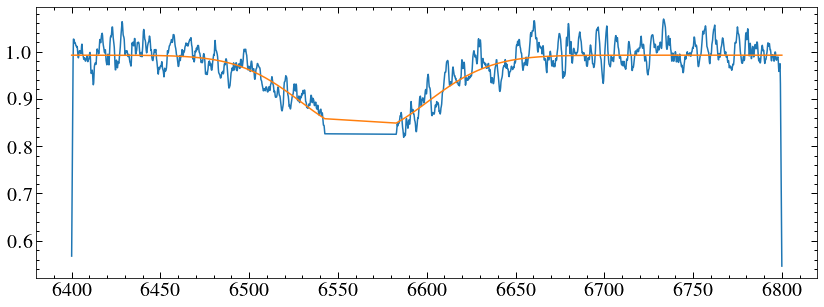

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_19_TAC.csv


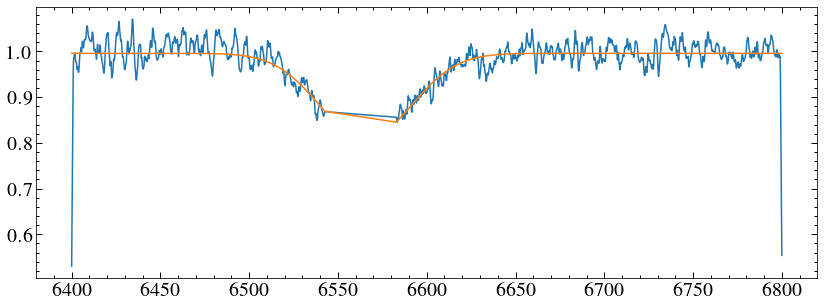

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_24_TAC.csv


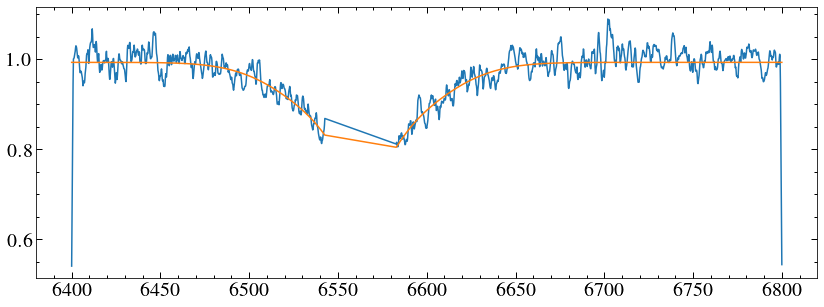

In [410]:
fitter = fitting.LevMarLSQFitter()
blank_dates = []
blank_dvs = []
blank_es = []
#abs_dvs = []
#abs_dves = []
#abs_dates = []
halpha = 6562.77
#h_em = []
#h_eme = []
#dvs_1 = []
#dvs_1e = []
#dvs_2 = []

#dvs_3 = []

def tiedfunc0(gg_init):
    mean = gg_init.mean_0.value
    return mean

for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
#for s, x in zip(sp_lines, xs):
    print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
    mask2 = (w> 6400) & (w < 6800) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    core_mask = (w < halpha-20) | (w > halpha+20)
    w, f, e  = w[core_mask], f[core_mask], e[core_mask]
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    blank_dates.append((date+150/86400))
    
    
    plt.figure() 
  #, bounds={'amplitude':[-0.1, -0.3]}
   # plt.axvline(halpha, c='r', ls='--')
    gg_init = models.Gaussian1D(-0.2, halpha,30.0)+models.Gaussian1D(-0.3, halpha,5) + models.Const1D(1.0) 

  #  gg_init.stddev_0.bounds = [1.5,6]
    
    
    gg_init.mean_1.tied=tiedfunc0

    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=100000)
    
    plt.plot(w,f)
    plt.plot(w, gg_fit(w))
    plt.show()
    
    #print(gg_fit)
    #print(fitter.fit_info['param_cov'])
    obs_lam = gg_fit[1].mean*u.AA
    #abs_dates.append(date)
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
    blank_dvs.append(dv)
     
    #em_line = gg_fit[4].mean*u.AA
  #  dv_em = em_line.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
   # h_em.append(dv_em)
    
    if fitter.fit_info['param_cov'] is None:
        blank_es.append(15)
    #    h_eme.append(15)
    else:
       # print('yes')
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        #print(len(fit_e))
       # print (fitter.fit_info)
        e_lam = fit_e[1]*u.AA
        e_up = (obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value         
        e_down = (obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value 
        e_up = abs(e_up- dv)        
        e_down = abs(e_down-dv) 
        es = np.mean([e_up, e_down])
        blank_es.append(es)
        
      #  e_lam = fit_e[9]*u.AA
      #  e_up = (em_line+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value         
      #  e_down = (em_line-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value 
      #  e_up = abs(e_up- dv_em)        
      #  e_down = abs(e_down-dv_em) 
      #  es = np.mean([e_up, e_down])
       # h_eme.append(es)
        
        

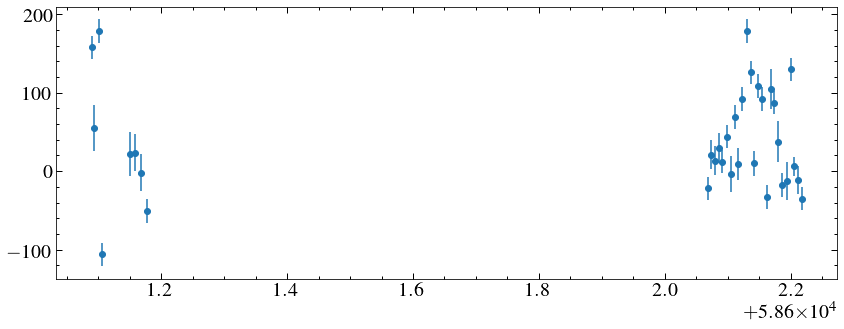

<ErrorbarContainer object of 3 artists>

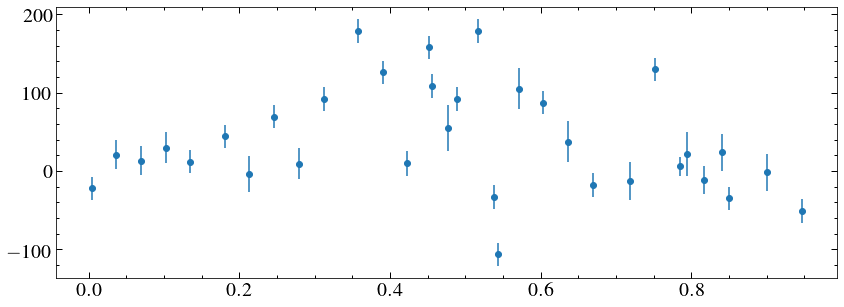

In [412]:
plt.errorbar(blank_dates, blank_dvs, yerr=blank_es,marker='o', ls='none')
plt.show()
plt.errorbar(((np.array(blank_dates)*24/4.23) %1), blank_dvs, yerr=blank_es,marker='o', ls='none')

Nope! Worth a try